In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import interpolate
from astropy.table import Table, Column, vstack, join

import palettable

cmap_1 = palettable.colorbrewer.sequential.Blues_7_r
cmap_2 = palettable.colorbrewer.sequential.OrRd_7_r
cmap_3 = palettable.colorbrewer.sequential.YlGn_7_r
cmap_4 = palettable.colorbrewer.sequential.Purples_7_r

cmap_list = [cmap_1, cmap_2, cmap_3, cmap_4]

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

In [18]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import scatter
from jianbing import catalog
from jianbing import wlensing

In [4]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

### Compare the outer envelope stellar mass and SDSS redMaPPer clusters
#### DSigma profiles of HSC massive galaxies

In [5]:
# DeltaSigma profiles of HSC massive galaxies
topn_massive = pickle.load(open(os.path.join(res_dir, 'topn_galaxies_sum.pkl'), 'rb'))

# DeltaSigma profiles of redMaPPer and CAMIRA clusters
topn_cluster = pickle.load(open(os.path.join(res_dir, 'topn_clusters_cen_sum.pkl'), 'rb'))

# For clusters, but using both central and satellite galaxies
topn_cluster_all = pickle.load(open(os.path.join(res_dir, 'topn_clusters_sum.pkl'), 'rb'))

#### DSigma profiles of mock galaxies

In [6]:
sim_dsig = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))

#### Halo mass distributions

In [7]:
sim_mhalo = Table.read(os.path.join(sim_dir, 'sim_merge_mhalo_hist.fits'))

#### Pre-compute lensing results for HSC galaxies

In [9]:
# Pre-compute
s16a_precompute = os.path.join(data_dir, 'topn_public_s16a_medium_precompute.hdf5')

hsc_pre = Table.read(s16a_precompute, path='hsc_extra')

red_sdss = Table.read(s16a_precompute, path='redm_sdss')

red_hsc = Table.read(s16a_precompute, path='redm_hsc')

#### Pre-compute lensing results for randoms

In [20]:
# Lensing data using medium photo-z quality cut
s16a_lensing = os.path.join(data_dir, 's16a_weak_lensing_medium.hdf5')

# Random
s16a_rand = Table.read(s16a_lensing, path='random')

#### Pre-defined number density bins

In [21]:
topn_bins = Table.read(os.path.join(bin_dir, 'topn_bins.fits'))

### Compute the DSigma profiles of SDSS redMaPPer clusters

- 0.2 < z < 0.38 clusters

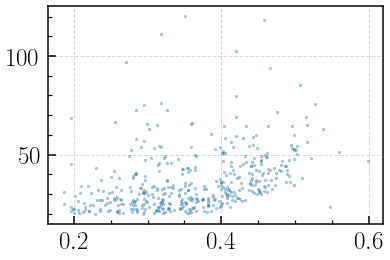

In [10]:
plt.scatter(red_sdss['z_best'], red_sdss['lambda_cluster_redm'], s=5, alpha=0.3)

In [16]:
mask = (red_sdss['z_best'] >= 0.2) & (red_sdss['z_best'] <= 0.4)

print(mask.sum())

264



# Using column: lambda_cluster_redm
# Bin 1:     0 -    52
# Bin 2:    53 -   248
# Dealing with Bin: 1
# Dealing with Bin: 2


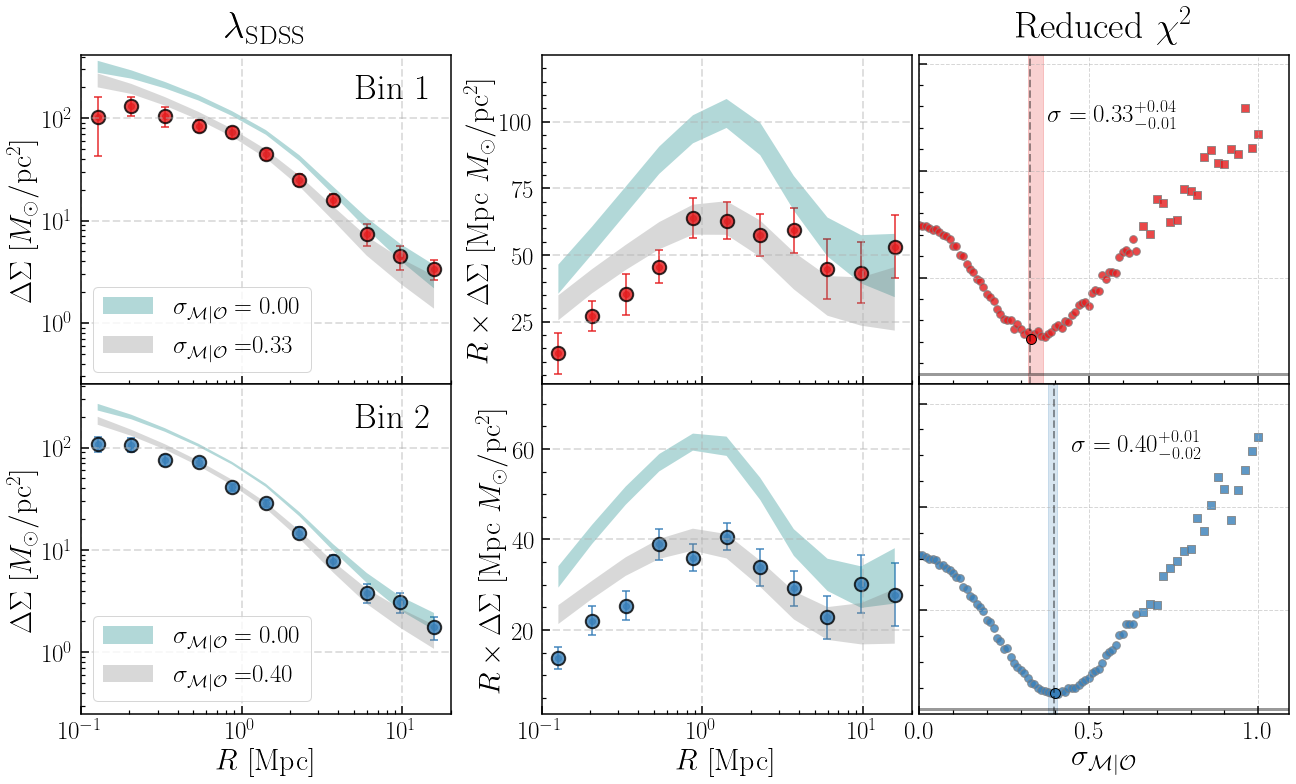

In [24]:
redm_sdss_dsig = wlensing.gather_topn_dsigma_profiles(
    red_sdss, s16a_rand, topn_bins[0:2], 'lambda_cluster_redm', 
    mask=mask, n_rand=100000, n_boot=200, verbose=True)

redm_sdss_sum = scatter.compare_model_dsigma(
    redm_sdss_dsig, sim_dsig, model_err=False, poly=True, verbose=True)

fig = visual.sum_plot_topn(
    redm_sdss_sum, r'$\lambda_{\rm SDSS}$', note=None, cov_type='jk', ref_tab=None)

### Compute the DSigma profiles of HSC redMaPPer clusters

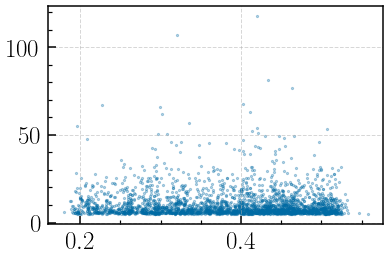

In [25]:
plt.scatter(red_hsc['z_best'], red_hsc['lambda'], s=5, alpha=0.3)

In [26]:
mask = (red_hsc['z_best'] >= 0.2) & (red_hsc['z_best'] <= 0.4)

print(mask.sum())

1362



# Using column: lambda
# Bin 1:     0 -    52
# Bin 2:    53 -   248
# Dealing with Bin: 1
# Dealing with Bin: 2


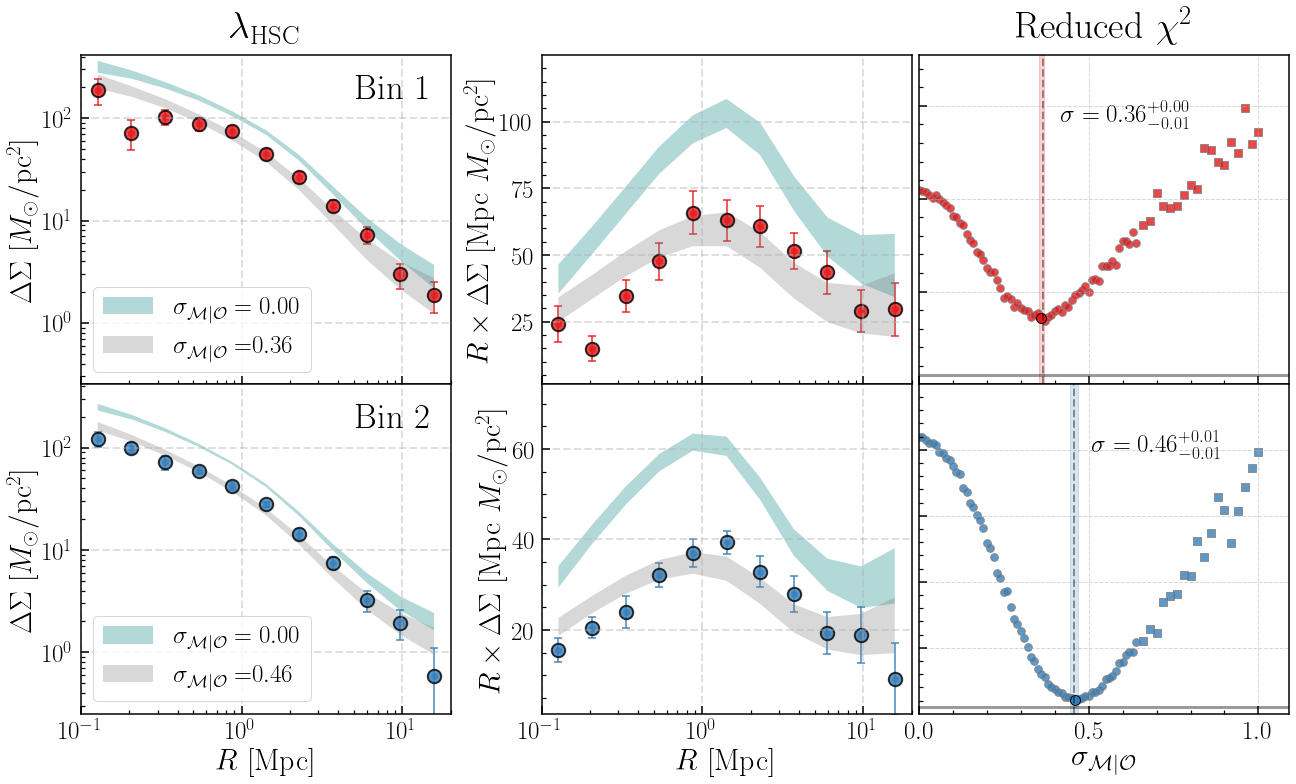

In [28]:
redm_hsc_dsig = wlensing.gather_topn_dsigma_profiles(
    red_hsc, s16a_rand, topn_bins[0:2], 'lambda', 
    mask=mask, n_rand=100000, n_boot=200, verbose=True)

redm_hsc_sum = scatter.compare_model_dsigma(
    redm_hsc_dsig, sim_dsig, model_err=False, poly=True, verbose=True)

fig = visual.sum_plot_topn(
    redm_hsc_sum, r'$\lambda_{\rm HSC}$', note=None, cov_type='jk', ref_tab=None)

### Compute the DSigma profiles of HSC massive galaxies

In [31]:
# S18A bright star mask
bsm_s18a = hsc_pre['flag'] > 0

# General mask for HSC galaxies
mask = (
    (hsc_pre['c82_100'] <= 18.) & (hsc_pre['logm_100'] - hsc_pre['logm_50'] <= 0.2) & (hsc_pre['logm_50_100'] > 0) &
    bsm_s18a & (hsc_pre['z'] >= 0.2) & (hsc_pre['z'] <= 0.4)
)

# Mask to select "central" galaxies
cen_mask_1 = hsc_pre['cen_mask_1'] > 0
cen_mask_2 = hsc_pre['cen_mask_2'] > 0
cen_mask_3 = hsc_pre['cen_mask_3'] > 0


# Using column: logm_50_100
# Bin 1:     0 -    52
# Bin 2:    53 -   248
# Dealing with Bin: 1
# Dealing with Bin: 2


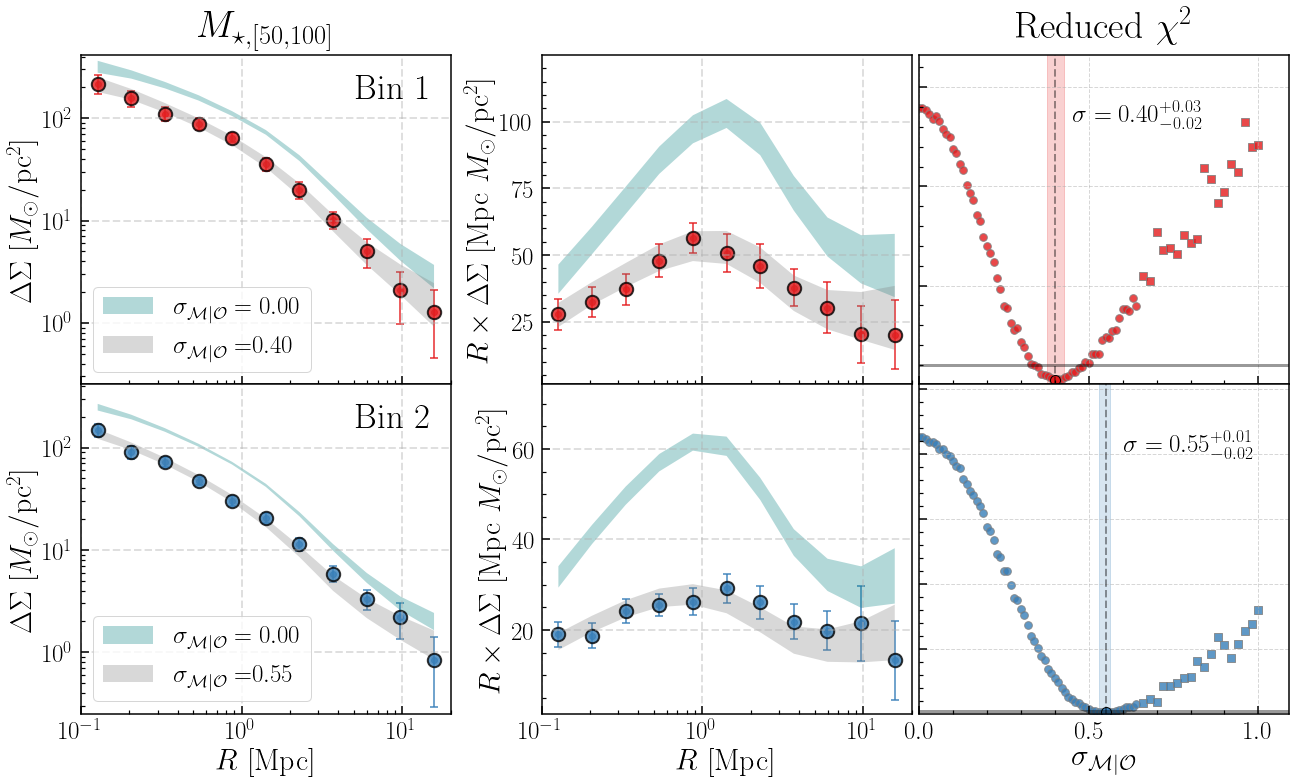

In [32]:
hsc_mout_dsig = wlensing.gather_topn_dsigma_profiles(
    hsc_pre, s16a_rand, topn_bins[0:2], 'logm_50_100', mask=(mask & cen_mask_3), 
    n_rand=100000, n_boot=200, verbose=True)

hsc_mout_sum = scatter.compare_model_dsigma(
    hsc_mout_dsig, sim_dsig, model_err=False, poly=True, verbose=True)

fig = visual.sum_plot_topn(
    hsc_mout_sum, r'$M_{\star, [50,100]}$', note=None, cov_type='jk', ref_tab=None)

<ipython-input-49-7a711be6486e>:22: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)
<ipython-input-49-7a711be6486e>:22: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)


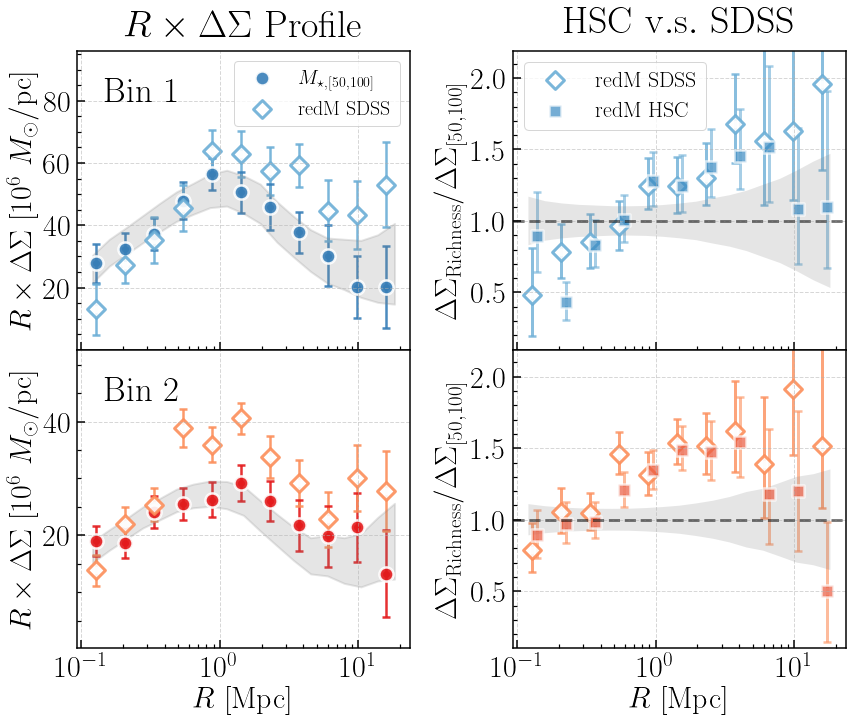

In [50]:
dsig_cmp_2 = redm_hsc_sum
label_cmp_2 = r'${\rm redM\ HSC}$'

dsig_cmp = redm_sdss_sum
label_cmp = r'${\rm redM\ SDSS}$'
sub_cmp = r'{\rm redM\ SDSS}z'

dsig_ref = hsc_mout_sum
label_ref = r'$M_{\star, [50, 100]}$'
sub_ref = r'{[50, 100]}'

fig = compare_dsigma_profiles(
    dsig_ref, dsig_cmp, sim_dsig, sig_type='bt', compare_to_model=True,
    label_ref=label_ref, label_cmp=label_cmp, sub_ref=sub_ref, sub_cmp=sub_cmp,
    marker_ref='o', marker_cmp='D', msize_ref=200, msize_cmp=160,
    dsig_cmp_2=dsig_cmp_2, label_cmp_2=label_cmp_2, mvir_min=12.8,
    middle_title=r'$\rm HSC\ v.s.\ SDSS$')

In [51]:
fig.savefig(os.path.join(fig_dir, 'fig_F1.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_F1.pdf'), dpi=120)

In [49]:
def compare_dsigma_profiles(dsig_ref, dsig_cmp, sim_dsig, sig_type='bt', compare_to_model=True,
                            label_ref=r'$\rm Ref$', label_cmp=r'$\rm Test$',
                            sub_ref=r'{\rm Ref}', sub_cmp=r'{\rm Test}',
                            cmap_list=None, color_bins=None, 
                            marker_ref='o', msize_ref=150,
                            marker_cmp='P', msize_cmp=180, 
                            show_best_cmp=False, middle_title=None, mvir_min=None,
                            dsig_cmp_2=None, label_cmp_2=r'$=rm Test 2$'):
    """Compare the Dsigma profiles."""

    def get_dsig_ratio(obs, ref, mod=None):
        """"""
        obs_rand = np.random.normal(
            loc=obs['dsigma'][0], scale=obs['dsig_err_{:s}'.format(sig_type)][0])

        if mod is not None:
            ref_rand = np.random.normal(
                loc=mod['dsig'], scale=(mod['dsig_err'] * err_factor))

            ref_inter = 10.0 ** (
                interpolate.interp1d(
                    mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)
            )
            return obs_rand / ref_inter
        else:
            ref_rand = np.random.normal(
                loc=ref['dsigma'][0], scale=obs['dsig_err_{:s}'.format(sig_type)][0])
            return obs_rand / ref_rand


    # Color maps and bins
    if cmap_list is None:
        cmap_list = [
            palettable.colorbrewer.sequential.Blues_7_r,
            palettable.colorbrewer.sequential.OrRd_7_r,
            palettable.colorbrewer.sequential.YlGn_7_r,
            palettable.colorbrewer.sequential.Purples_7_r]

    if color_bins is None:
        color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

    # Radius bin of the observed DSigma profiles
    r_mpc_obs = dsig_ref.meta['r_mpc']

    # ---- Start the figure ---- #

    # Setup the figure
    n_col, n_bins = 2, len(dsig_ref)
    fig_y = int(4.2 * n_bins + 2)
    left, right = 0.10, 0.995
    if n_bins == 4:
        bottom, top = 0.055, 0.96
    elif n_bins == 3:
        bottom, top = 0.08, 0.96
    elif n_bins == 2:
        bottom, top = 0.10, 0.93
        
    x_space = 0.12
    x_size = (right - left - x_space * 1.05) / n_col
    y_size = (top - bottom) / n_bins
    
    fig = plt.figure(figsize=(12, fig_y))

    for bin_id in np.arange(len(dsig_ref)) + 1:
        # Setup the three columns
        ax1 = fig.add_axes([left, top - y_size * bin_id, x_size, y_size])
        ax2 = fig.add_axes([left + x_space + x_size, top - y_size * bin_id, x_size, y_size])

        # Subplot title
        if bin_id == 1:
            ax1.set_title(r'$R \times \Delta\Sigma\ \rm Profile$', fontsize=38, pad=18)
            if middle_title is None:
                ax2.set_title(r'${\rm Richness\ v.s.}\ M_{\star,\ \rm Outer}$', fontsize=38, pad=18)
            else:
                ax2.set_title(middle_title, fontsize=38, pad=18)

        # Color map
        cmap, color = cmap_list[bin_id - 1], color_bins[bin_id - 1]

        # MDPL halo mass information for this bin
        sim_dsig_bin = sim_dsig[sim_dsig['bin'] == bin_id - 1]

        # DSigma result for this bin
        dsig_ref_bin = dsig_ref[dsig_ref['bin_id'] == bin_id]
        dsig_cmp_bin = dsig_cmp[dsig_cmp['bin_id'] == bin_id]

        # Best fit DSigma profiles
        dsig_ref_best = sim_dsig_bin[
            np.argmin(
                np.abs(sim_dsig_bin['scatter'] - dsig_ref_bin['sig_med_{:s}'.format(sig_type)]))]
        dsig_cmp_best = sim_dsig_bin[
            np.argmin(
                np.abs(sim_dsig_bin['scatter'] - dsig_cmp_bin['sig_med_{:s}'.format(sig_type)]))]

        if dsig_ref_bin['sig_med_{:s}'.format(sig_type)] < 0.6:
            err_factor = 5.
        else:
            err_factor = 4.

        # Interpolated the reference model profile
        ref_model_inter = 10.0 ** (
            interpolate.interp1d(
                dsig_ref_best['r_mpc'], np.log10(dsig_ref_best['dsig']),
                fill_value='extrapolate')(r_mpc_obs)
        )

        if compare_to_model:
            ratio_sample = [
                get_dsig_ratio(
                    dsig_cmp_bin, dsig_ref_bin, mod=dsig_ref_best) for i in np.arange(2000)]
            ratio_cmp = dsig_cmp_bin['dsigma'][0] / ref_model_inter
        else:
            ratio_sample = [
                get_dsig_ratio(dsig_cmp_bin, dsig_ref_bin, mod=None) for i in np.arange(2000)]
            ratio_cmp = dsig_cmp_bin['dsigma'][0] / dsig_ref_bin['dsigma'][0]

        ratio_cmp_err_low = ratio_cmp - np.nanpercentile(ratio_sample, 16, axis=0)
        ratio_cmp_err_upp = np.nanpercentile(ratio_sample, 84, axis=0) - ratio_cmp
        
        if dsig_cmp_2 is not None:
            try:
                dsig_cmp_2_bin = dsig_cmp_2[dsig_cmp_2['bin_id'] == bin_id]
                dsig_cmp_2_best = sim_dsig_bin[
                    np.argmin(
                        np.abs(sim_dsig_bin['scatter'] - dsig_cmp_2_bin['sig_med_{:s}'.format(sig_type)]))]

                if compare_to_model:
                    ratio_sample = [
                        get_dsig_ratio(
                            dsig_cmp_2_bin, dsig_ref_bin, mod=dsig_ref_best) for i in np.arange(2000)]
                    ratio_cmp_2 = dsig_cmp_2_bin['dsigma'][0] / ref_model_inter
                else:
                    ratio_sample = [
                        get_dsig_ratio(dsig_cmp_2_bin, dsig_ref_bin, mod=None) for i in np.arange(2000)]
                    ratio_cmp_2 = dsig_cmp_2_bin['dsigma'][0] / dsig_ref_bin['dsigma'][0]

                ratio_cmp_2_err_low = ratio_cmp_2 - np.nanpercentile(ratio_sample, 16, axis=0)
                ratio_cmp_2_err_upp = np.nanpercentile(ratio_sample, 84, axis=0) - ratio_cmp_2
                show_cmp_2 = True
            except Exception:
                show_cmp_2 = False
        else:
            show_cmp_2 = False

        # Halo mass distribution from model
        if bin_id == 1:
            n_bins = 8
        elif bin_id == 2:
            n_bins = 4
        else:
            n_bins = 3

        # ----- Plot 1: R x DSigma plot ----- #
        ax1.set_xscale("log", nonpositive='clip')

        # MDPL: Best-fit
        ax1.fill_between(
            dsig_ref_best['r_mpc'],
            dsig_ref_best['r_mpc'] * (
                dsig_ref_best['dsig'] - dsig_ref_best['dsig_err'] * err_factor),
            dsig_ref_best['r_mpc'] * (
                dsig_ref_best['dsig'] + dsig_ref_best['dsig_err'] * err_factor),
            alpha=0.2, edgecolor='grey', linewidth=2.0,
            label=r'__no_label__', facecolor='grey', linestyle='-', rasterized=True)

        if show_best_cmp:
            ax1.fill_between(
                dsig_cmp_best['r_mpc'],
                dsig_cmp_best['r_mpc'] * (
                    dsig_cmp_best['dsig'] - dsig_cmp_best['dsig_err'] * err_factor),
                dsig_cmp_best['r_mpc'] * (
                    dsig_cmp_best['dsig'] + dsig_cmp_best['dsig_err'] * err_factor),
                alpha=0.15, edgecolor='grey', linewidth=2.0,
                label=r'__no_label__', facecolor='grey', linestyle='--', rasterized=True)

        # Reference DSigma profile
        ax1.errorbar(
            r_mpc_obs,
            r_mpc_obs * dsig_ref_bin['dsigma'][0],
            yerr=(r_mpc_obs * dsig_ref_bin['dsig_err_{:s}'.format(sig_type)][0]),
            ecolor=color, color=color, alpha=0.9, capsize=4, capthick=2.5, elinewidth=2.5,
            label='__no_label__', fmt='o', zorder=0)
        ax1.scatter(
            r_mpc_obs,
            r_mpc_obs * dsig_ref_bin['dsigma'][0],
            s=msize_ref, alpha=0.9, facecolor=color, edgecolor='w', marker=marker_ref, 
            linewidth=2.5, label=label_ref)

        # DSigma profiles to compare with
        ax1.errorbar(
            r_mpc_obs * 1.01,
            r_mpc_obs * dsig_cmp_bin['dsigma'][0],
            yerr=(r_mpc_obs * dsig_cmp_bin['dsig_err_{:s}'.format(sig_type)][0]),
            ecolor=cmap.mpl_colormap(0.5), color='w', alpha=0.9, capsize=4, capthick=2.5,
            elinewidth=2.5, label='__no_label__', fmt='o', zorder=0)
        ax1.scatter(
            r_mpc_obs * 1.01,
            r_mpc_obs * dsig_cmp_bin['dsigma'][0],
            s=msize_cmp, alpha=0.9, facecolor='w', edgecolor=cmap.mpl_colormap(0.5), 
            marker=marker_cmp, linewidth=3.0, label=label_cmp)

        y_max = np.max(
            [np.max(dsig_ref_best['r_mpc'] * dsig_ref_best['dsig']), 
             np.max(dsig_cmp_best['r_mpc'] * dsig_cmp_best['dsig'])]) * 1.5
        ax1.set_ylim(0.1, y_max)

        # Bin ID
        _ = ax1.text(
            0.08, 0.83, r'$\rm Bin\ {:1d}$'.format(bin_id), fontsize=35, transform=ax1.transAxes)
        
        if bin_id == 1:
            ax1.legend(loc='best', fontsize=20)

        if bin_id == len(dsig_ref):
            _ = ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
        else:
            ax1.set_xticklabels([])
        _ = ax1.set_ylabel(r'$R \times \Delta\Sigma\ [10^{6}\ M_{\odot}/\mathrm{pc}]$', fontsize=30)


        # ----- Plot 2: Ratio of DSigma plot ----- #
        ax2.set_xscale("log", nonpositive='clip')

        ax2.axhline(
            1.0, linewidth=3.0, alpha=0.5, color='k', linestyle='--', label='__no_label__', )

        # Uncertainty of the model
        ax2.fill_between(
            dsig_ref_best['r_mpc'],
            1.0 - (dsig_ref_best['dsig_err'] * err_factor / dsig_ref_best['dsig']),
            1.0 + (dsig_ref_best['dsig_err'] * err_factor / dsig_ref_best['dsig']),
            alpha=0.2, edgecolor='none', linewidth=1.0, label='__no_label__',
            facecolor='grey', rasterized=True)

        ax2.errorbar(
            r_mpc_obs, ratio_cmp, yerr=[ratio_cmp_err_low, ratio_cmp_err_upp],
            ecolor=cmap.mpl_colormap(0.5), color='w', alpha=0.8, capsize=4, capthick=2.5,
            elinewidth=3.0, label='__no_label__', fmt='o', zorder=0)
        ax2.scatter(
            r_mpc_obs, ratio_cmp,
            s=msize_cmp, alpha=0.9, facecolor='w', edgecolor=cmap.mpl_colormap(0.5),
            marker=marker_cmp, linewidth=3.0, label=label_cmp)
        
        if show_cmp_2:
            ax2.errorbar(
                r_mpc_obs * 1.09, ratio_cmp_2, yerr=[ratio_cmp_2_err_low, ratio_cmp_2_err_upp],
                ecolor=cmap.mpl_colormap(0.5), color='w', alpha=0.6, capsize=4, capthick=2.5,
                elinewidth=3.0, label='__no_label__', fmt='o', zorder=0)
            ax2.scatter(
                r_mpc_obs * 1.09, ratio_cmp_2,
                s=165, alpha=0.7, facecolor=cmap.mpl_colormap(0.3), edgecolor='w',
                marker='s', linewidth=2.5, label=label_cmp_2)

        ax2.set_ylim(0.1, 2.19)

        if np.max(ratio_cmp) < 1.2:
            y_pos = 0.85
        else:
            y_pos = 0.15

        if bin_id == 1:
            ax2.legend(loc='best', fontsize=22)

        if bin_id == len(dsig_ref):
            _ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
        else:
            ax2.set_xticklabels([])
            
        _ = ax2.set_ylabel(r'$\Delta\Sigma_{\rm Richness}/\Delta\Sigma_{[50, 100]}$', fontsize=30)

        for tick in ax1.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax1.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

        for tick in ax2.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax2.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

    return fig